# Correlation (상관관계)
`06_corr.ipynb`

## 정의
- 두 변수간에 서로 얼마나 함께 변하는지 정도를 나타내는 통계 개념
- 값의 범위는 : -1 ~ +1
    - +1: 완벽한 양의 상관관계 -> x가 증가하면 y도 비례해서 증가 : 키 - 몸무게
    - 0: 상관 없음 : 키와 수학점수
    - -1: 완벽한 음의 상관관계 -> x가 증가하면 y가 비례해서 감소 : 운동량 - 체지방률

## 상관 계수 ($r$)
두 변수간의 관계가 얼마나 강한지 측정하는 법 (대표)
- 피어슨 (Pearson): 가장 많이 쓰임. 연속 변수 선형 관계 측정
- 스피어맨 (Spearman): 순위(랭크) 기반, 비 선형 관계, 이상치에 강함
- 켄달 (Kendall) : 순위 일관성 기반, 표본이 적을 때 안정적

In [15]:
%pip install -q kagglehub[pandas-datasets]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


df = pd.read_csv('./OnlineRetail.csv', encoding='ISO-8859-1')

In [17]:
from da_utils import profile, outliers, patterns

# 데이터 프로파일링
profile.get_data_profile(df)

종합 데이터 품질 리포트

1. 기본정보
- 데이터 크기: 541909행 x 8열
- 메모리 사용량: 173.12mb
- 수치형 변수: 3개
- 범주형 변수: 5개

2. 결측값 분석
⚠️


,결측수,결측율(%)
Description,1454,0.27
CustomerID,135080,24.93



3. 수치형 변수 품질 분석


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,Quantity,9.552,218.081,-80995.00,80995.0,-0.264,119769.160,10.817,0.133
1,UnitPrice,4.611,96.760,-11062.06,38970.0,186.507,59005.719,7.312,0.301
2,CustomerID,15287.691,1713.600,12346.00,18287.0,0.030,-1.180,0.000,1.075



4. 분포 이상 감지

- 극심한 왜도 (|skewness|>2)
⚠️
-- UnitPrice: 왜도 = 186.507

- 높은 이상값 비율(>5%)
⚠️
-- Quantity: 이상값 10.8%
-- UnitPrice: 이상값 7.3%


,변수명,평균,표준편차,최솟값,최댓값,왜도,첨도,이상값비율(%),유일값비율(%)
0,Quantity,9.552,218.081,-80995.00,80995.0,-0.264,119769.160,10.817,0.133
1,UnitPrice,4.611,96.760,-11062.06,38970.0,186.507,59005.719,7.312,0.301
2,CustomerID,15287.691,1713.600,12346.00,18287.0,0.030,-1.180,0.000,1.075


=== 결측값 패턴 분석 ===
변수별 결측 현황


,결측수,결측률(%)
CustomerID,135080,24.93
Description,1454,0.27


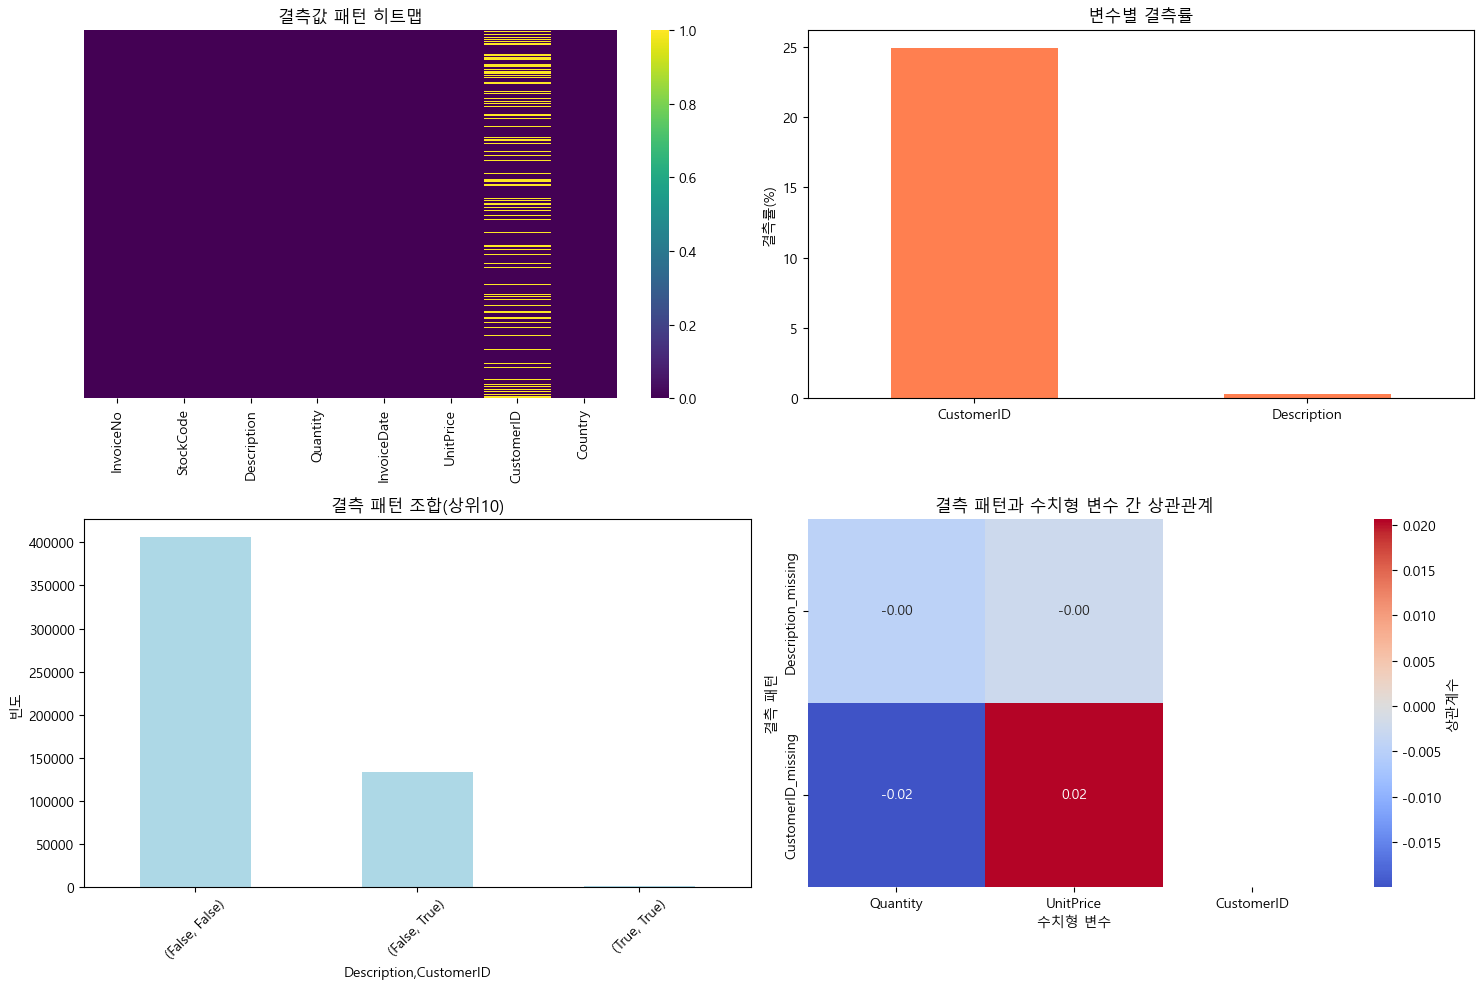

,결측수,결측률(%)
CustomerID,135080,24.93
Description,1454,0.27


In [18]:
# 결측치 모니터링 함수 
patterns.analyze_missing_patterns(df)

In [19]:
# 이상치 탐지 함수 (결측치 처리후 실행 필요)
outliers.outlier_detection(df, 0.999, iso_cont='auto', final_threshold=2)

결측치 확인. 처리후 재시도 하세요


In [20]:
print('전체 거래', len(df))
print('고유 InvoiceNo', df['InvoiceNo'].nunique())
print('고유 고객수', df['CustomerID'].nunique())

전체 거래 541909
고유 InvoiceNo 25900
고유 고객수 4372


In [21]:
# 데이터 전처리
df_clean = df.copy()

# CustomerID 결측값 제거 (고객 단위 분석을 위해 필수)
missing_customers = df_clean['CustomerID'].isnull().sum()
print(f'CustomerID 결측값 제거: {missing_customers}건')
df_clean = df_clean.dropna(subset=['CustomerID'])

# 취소 거래 분리 (InvoiceNo 가 'C' 로 시작)
cancel_mask = df_clean['InvoiceNo'].astype('str').str.startswith('C')
# 취소거래, 정상거래 분리
df_cancel = df_clean[cancel_mask]
df_clean = df_clean[~cancel_mask]
print(f'취소거래 분리: {len(df_cancel)}건')
print(f'정상 거래: {len(df_clean)}건')

# df_clean에 파생 변수 생성 (상관 관계 분석)
# TotalAmount, InvoiceDate(DateTime), Year, Month, DayOfWeek(숫자), Hour, DayName(글자), CustomerID(Str)
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int).astype(str)
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month']= df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek']= df_clean['InvoiceDate'].dt.dayofweek
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['DayName'] = df_clean['InvoiceDate'].dt.day_name()

print('\n=== 이상값 확인 ===')
print(f'음수 수량: {(df_clean['Quantity'] < 0).sum()}')
print(f'음수 단가: {(df_clean['UnitPrice'] < 0).sum()}')
print(f'0 단가: {(df_clean['UnitPrice'] == 0).sum()}')

# 양수 수량 & 양수 단가 데이터만 살리기
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

df_clean.info()

CustomerID 결측값 제거: 135080건
취소거래 분리: 8905건
정상 거래: 397924건

=== 이상값 확인 ===
음수 수량: 0
음수 단가: 0
0 단가: 40
<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
 8   TotalAmount  397884 non-null  float64       
 9   Year         397884 non-null  int32         
 10  Month        397884 non-null  int32         
 11  DayOfWeek    397884 non-null  int32         
 12  Hour         397884 non-null  int32         
 13  DayName      397884 non-null  object   

In [22]:
print('=== 고객별 구매 패턴 특성 DF 생성 ===')

customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo':  'nunique',  # 구매 횟수(Frequency)
    'Quantity': ['sum', 'mean'],  # 총구매량, 평균구매량
    'UnitPrice': 'mean',  # 평균 단가
    'TotalAmount': ['sum', 'mean'],  # 총 구매액(Monetary), 평균 구매액
    'StockCode': 'nunique',  # 구매한 상품 종류 수
    'InvoiceDate': ['min', 'max'],  # 첫 구매일, 마지막 구매일
}).round(2)

# 컬럼명 정리 (구매횟수==F, 총구매액==M)
customer_stats.columns = ['Frequency', '총구매량', '평균구매량', '평균단가', 
                        'Monetary', '평균구매액', '상품종류수', '첫구매일', '마지막구매일']

# 구매 기간 및 주기 계산 (추가하기)
customer_stats['구매기간일수'] = (customer_stats['마지막구매일'] - customer_stats['첫구매일']).dt.days + 1
customer_stats['구매주기'] = customer_stats['구매기간일수'] / customer_stats['Frequency']

# RFM 분석 변수
analysis_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
customer_stats['Recency'] = (analysis_date - customer_stats['마지막구매일']).dt.days


# RFM점수 (모두 5등급) (.qcut으로 5등분)
customer_stats['R_score'] = pd.qcut(customer_stats['Recency'], 5, labels=[5,4,3,2,1])
customer_stats['F_score'] = pd.qcut(customer_stats['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
customer_stats['M_score'] = pd.qcut(customer_stats['Monetary'], 5, labels=[1,2,3,4,5])
customer_stats['RFM_score'] = (customer_stats['R_score'].astype(str) + \
                                customer_stats['F_score'].astype(str) + \
                                customer_stats['M_score'].astype(str))
# 추가정보
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']

# 가격 민감도 - 단가가 상대적으로 일관되게 유지되는가?
# CV = Coefficient of Variation (표준편차 / 평균) => 높으면, 다양한 가격대로 산다 / 낮으면, 특정 가격대에 고정적 구매
price_cv = df_clean.groupby('CustomerID')['UnitPrice'].agg(['mean', 'std'])
price_cv['가격변동성'] = (price_cv['std'] / price_cv['mean']).fillna(0)

customer_stats = customer_stats.merge(
    price_cv[['가격변동성']], # 두 DF 다 컬럼이 아닌 인덱스가 CustomerID
    left_index=True,   # customer_stats의 인덱스 기준으로 병합
    right_index=True   # price_cv의 인덱스 기준으로 병합
)

customer_stats


=== 고객별 구매 패턴 특성 DF 생성 ===


,Frequency,총구매량,평균구매량,평균단가,Monetary,평균구매액,상품종류수,첫구매일,마지막구매일,구매기간일수,구매주기,Recency,R_score,F_score,M_score,RFM_score,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1,1.000000,326,1,1,5,115,74215.000000,1.000000,0.000000
12347,7,2458,13.51,2.64,4310.00,23.68,103,2010-12-07 14:57:00,2011-12-07 15:52:00,366,52.285714,2,5,5,5,555,351.142857,14.714286,0.853015
12348,4,2341,75.52,5.76,1797.24,57.98,22,2010-12-16 19:09:00,2011-09-25 13:13:00,283,70.750000,75,2,4,4,244,585.250000,5.500000,2.324492
12349,1,631,8.64,8.29,1757.55,24.08,73,2011-11-21 09:51:00,2011-11-21 09:51:00,1,1.000000,19,4,1,4,414,631.000000,73.000000,4.225823
12350,1,197,11.59,3.84,334.40,19.67,17,2011-02-02 16:01:00,2011-02-02 16:01:00,1,1.000000,310,1,1,2,112,197.000000,17.000000,2.430180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,1,45,4.50,4.76,180.60,18.06,10,2011-03-07 09:52:00,2011-03-07 09:52:00,1,1.000000,278,1,2,1,121,45.000000,10.000000,0.518798
18281,1,54,7.71,5.62,80.82,11.55,7,2011-06-12 10:53:00,2011-06-12 10:53:00,1,1.000000,181,1,2,1,121,54.000000,7.000000,1.383397
18282,2,103,8.58,5.20,178.05,14.84,12,2011-08-05 13:35:00,2011-12-02 11:43:00,119,59.500000,8,5,3,1,531,51.500000,6.000000,0.937819


In [24]:
print('=== 기본 상관관계 분석 ===')

numeric_cols =  ['Frequency', '총구매량', '평균구매량', '평균단가', 'Monetary', 
                   '평균구매액', '상품종류수', '구매기간일수', '구매주기', 'Recency', 
                   'Frequency', 'Monetary', '평균장바구니크기', '거래당상품종류', '가격변동성']
    
correlation_data = customer_stats[numeric_cols]
correlation_data

=== 기본 상관관계 분석 ===


,Frequency,총구매량,평균구매량,평균단가,Monetary,평균구매액,상품종류수,구매기간일수,구매주기,Recency,Frequency,Monetary,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,1,1.000000,326,1,77183.60,74215.000000,1.000000,0.000000
12347,7,2458,13.51,2.64,4310.00,23.68,103,366,52.285714,2,7,4310.00,351.142857,14.714286,0.853015
12348,4,2341,75.52,5.76,1797.24,57.98,22,283,70.750000,75,4,1797.24,585.250000,5.500000,2.324492
12349,1,631,8.64,8.29,1757.55,24.08,73,1,1.000000,19,1,1757.55,631.000000,73.000000,4.225823
12350,1,197,11.59,3.84,334.40,19.67,17,1,1.000000,310,1,334.40,197.000000,17.000000,2.430180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,1,45,4.50,4.76,180.60,18.06,10,1,1.000000,278,1,180.60,45.000000,10.000000,0.518798
18281,1,54,7.71,5.62,80.82,11.55,7,1,1.000000,181,1,80.82,54.000000,7.000000,1.383397
18282,2,103,8.58,5.20,178.05,14.84,12,119,59.500000,8,2,178.05,51.500000,6.000000,0.937819
